In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

BATCH_SIZE = 128
RE_SR = 44100
EPOCHS = 3
LR = 1e-2


feature_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((200,200)),
    T.ToTensor()
])

label_transform = T.Compose([
    T.ToTensor()
])

cuda


In [13]:
def wav2melSpec(AUDIO_PATH):
    y, sr = librosa.load(AUDIO_PATH)
    audio = librosa.resample(y=y, orig_sr=sr, target_sr=RE_SR)
    return librosa.feature.mfcc(y=audio, sr=sr, n_fft=1024, n_mels=26, n_mfcc=26, hop_length=1024, win_length=1024)

def imgSpec(ms_feature):
    fig, ax = plt.subplots()
    ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    print(ms_feature.shape)
    img = librosa.display.specshow(ms_dB, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram');
    
def hear_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH) 
    print("\t", end="")
    ipd.display(ipd.Audio(data=audio, rate=sr))
    
def get_audio_info(path, show_melspec=False, label=None):
    spec = wav2melSpec(path)
    if label is not None:
        print("Label:", label)
    if show_melspec is not False:
        imgSpec(spec)
    hear_audio(path)

In [14]:
# make two classes for dataset for features
# one returns mel spec
# one returns label
# split

class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None, train=True, train_size=0.80):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] == "wav":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))
        
        total_len = len(self.file_list)
        
        # if train:
        #    self.file_list, self.label_list = self.file_list[:int(0.80 * total_len)], self.label_list[:int(0.80 * total_len)]
        # else:
        #    self.file_list, self.label_list = self.file_list[int(0.80 * total_len):], self.label_list[int(0.80 * total_len):]
                    
    def __getitem__(self, idx):
        try:
            spec = wav2melSpec(self.file_list[idx])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
        except:
            spec = wav2melSpec(self.file_list[0])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
    
    def __len__(self):
        return len(self.file_list)

37261 19174
Label: 1
(26, 144)
	

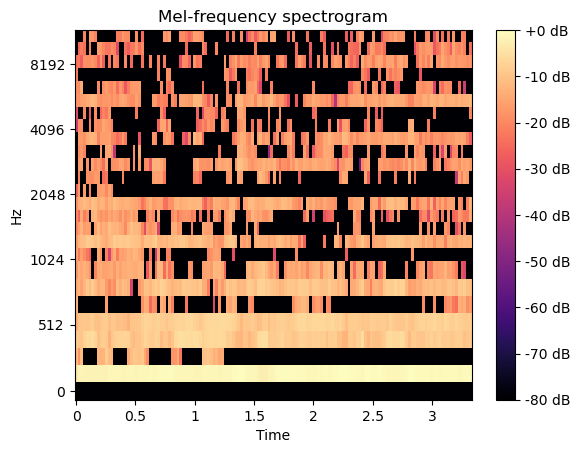

In [15]:
train_ds = AudioDataset('C:\AI\SAFE_dataset\_TRAIN', feature_transform=feature_transform, label_transform=T.ToTensor(), train=True)
test_ds = AudioDataset('C:\AI\SAFE_dataset\_TEST', feature_transform=feature_transform, label_transform=T.ToTensor(), train=False)
print(len(train_ds), len(test_ds))

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

trainimages, trainlabels, traintext = next(iter(train_dataloader))
trainimages.shape, trainlabels.shape

check = 10
get_audio_info(traintext[check], True, trainlabels[check].item())

In [16]:
class AudioClassifier(nn.Module):
    def __init__(self, num_feature_maps, layers):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//2),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//4),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_feature_maps//4, num_feature_maps//8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//8),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//8, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )
        
        self.classifier = nn.ModuleList(
            [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        )
        
    def forward(self, x):
        a = self.conv_layer(x)
        for layer in self.classifier:
            a = layer(a)
        return a # as logits

In [17]:
"""
class AudioClassifier(nn.Module):
    def __init__(self, num_feature_maps, layers):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//2),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//4),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_feature_maps//4, num_feature_maps//8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//8),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//8, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )
        
        self.classifier = nn.ModuleList(
            [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        )
        
    def forward(self, x):
        a = self.conv_layer(x)
        for layer in self.classifier:
            a = layer(a)
        return a # as logits

        
num_feature_maps = 64
layers = [81, 32, 16, 8, 4, 2]
"""

'\nclass AudioClassifier(nn.Module):\n    def __init__(self, num_feature_maps, layers):\n        super().__init__()\n        self.conv_layer = nn.Sequential(\n            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),\n            nn.ReLU(inplace=True),\n            \n            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),\n            nn.BatchNorm2d(num_feature_maps//2),\n            nn.LeakyReLU(inplace=True),\n            \n            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),\n            nn.BatchNorm2d(num_feature_maps//4),\n            nn.ReLU(inplace=True),\n\n            nn.Conv2d(num_feature_maps//4, num_feature_maps//8, kernel_size=4, stride=2, padding=1, bias=False),\n            nn.BatchNorm2d(num_feature_maps//8),\n            nn.LeakyReLU(inplace=True),\n            \n            nn.Conv2d(num_feature_maps//8, 1, kernel_size=4, stride=1, pa

In [18]:
num_feature_maps = 64
layers = [81, 32, 16, 8, 4, 2]

clf = AudioClassifier(num_feature_maps, layers).to(device)
print(clf)

optim = torch.optim.Adam(lr=LR, params=clf.parameters(), betas=(0.5, 0.99))
loss_fn = nn.CrossEntropyLoss()

AudioClassifier(
  (conv_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(8, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): ModuleList(
    (0): Linear(in_features=81, out_features=32, bias=Tru

In [19]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model, dataloader, optim, loss_fn, accuracy_fn):
    train_loss = 0.0
    train_acc = 0.0
    train_loss_arr = []
    train_acc_arr = []    
    
    model.train()
    for batch, (X,y,txt) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_logits = model(X).to(device)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)
        
        acc = accuracy_fn(y_preds, y)
        loss = loss_fn(y_logits, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        train_acc += acc

        loss_str = str(loss)
        loss_str = loss_str[7:13]
        acc_str = str(acc)
        loss_float = float(loss_str)
        acc_float = float(acc_str)
        train_loss_arr.append(loss_float)
        train_acc_arr.append(acc_float)
        
        if batch % 50 == 0:
            sample = random.randint(0, BATCH_SIZE-2)
            print(f"\tBatch {batch}: Train loss: {loss:.5f} | Train accuracy : {acc:.2f}%")
            get_audio_info(txt[sample], label=y_preds[sample].item())
            print("----------------------------------------")
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss_arr, train_acc_arr

    
def eval_step(model, dataloader, optim, loss_fn, accuracy_fn):
    test_loss = 0.0
    test_acc = 0.0
    test_loss_arr = []
    test_acc_arr = []  
    
    model.eval()
    with torch.inference_mode():
        for batch, (X,y,txt) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
        
            y_logits = model(X).to(device)
            y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

            acc = accuracy_fn(y_preds, y)
            loss = loss_fn(y_logits, y)

            test_loss += loss.item()
            test_acc += acc

            loss_str = str(loss)
            loss_str = loss_str[7:13]
            acc_str = str(acc)
            loss_float = float(loss_str)
            acc_float = float(acc_str)
            test_loss_arr.append(loss_float)
            test_acc_arr.append(acc_float)

            if batch % 50 == 0:
                sample = random.randint(0, BATCH_SIZE-2)
                print(f"\tBatch {batch}: Test loss: {loss:.5f} | Test accuracy : {acc:.2f}%")
                get_audio_info(txt[sample], label=y_preds[sample].item())
                print("----------------------------------------")
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    return test_loss_arr, test_acc_arr

In [20]:
model_save_dir = './models'
os.makedirs(model_save_dir, exist_ok=True)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    try:
        train_loss, train_acc = train_step(clf, train_dataloader, optim, loss_fn, accuracy)
        test_loss, test_acc = eval_step(clf, test_dataloader, optim, loss_fn, accuracy)

        # print(train_loss)
        # print(test_acc)
        # print(train_loss)
        # print(test_acc)

        for _ in train_loss:
            train_loss_history.append(_)
        for _ in train_acc:    
            train_acc_history.append(_)
        for _ in test_loss:
            test_loss_history.append(_)
        for _ in test_acc:
            test_acc_history.append(_)

        model_save_path = os.path.join(model_save_dir, f'model_epoch_{epoch+1}.pt')
        torch.save(clf.state_dict(), model_save_path)
        print(f"모델이 {model_save_path}에 저장되었습니다.")
    except:
        continue

Epoch 0
	Batch 0: Train loss: 0.91194 | Train accuracy : 21.09%
Label: 0
	

----------------------------------------


c:\Users\mosfet\anaconda3\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=0
  warnings.warn(
C:\Users\mosfet\AppData\Local\Temp\ipykernel_6152\1755252145.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(AUDIO_PATH)
c:\Users\mosfet\anaconda3\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


	Batch 50: Train loss: 0.09214 | Train accuracy : 96.09%
Label: 1
	

----------------------------------------
	Batch 100: Train loss: 0.07207 | Train accuracy : 96.88%
Label: 1
	

----------------------------------------
	Batch 150: Train loss: 0.02152 | Train accuracy : 99.22%
Label: 1
	

----------------------------------------
	Batch 200: Train loss: 0.00178 | Train accuracy : 100.00%
Label: 0
	

----------------------------------------
	Batch 250: Train loss: 0.04893 | Train accuracy : 98.44%
Label: 1
	

----------------------------------------
Train loss: 0.07673 | Train accuracy: 97.02%
	Batch 0: Test loss: 0.03655 | Test accuracy : 99.22%
Label: 1
	

----------------------------------------
	Batch 50: Test loss: 0.00500 | Test accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 100: Test loss: 0.01740 | Test accuracy : 99.22%
Label: 1
	

----------------------------------------
Test loss: 0.01505 | Test accuracy: 99.48%
모델이 ./models\model_epoch_1.pt에 저장되었습니다.
Epoch 1
	Batch 0: Train loss: 0.03145 | Train accuracy : 98.44%
Label: 1
	

----------------------------------------
	Batch 50: Train loss: 0.02218 | Train accuracy : 99.22%
Label: 1
	

----------------------------------------
	Batch 100: Train loss: 0.00449 | Train accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 150: Train loss: 0.00221 | Train accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 200: Train loss: 0.03148 | Train accuracy : 99.22%
Label: 0
	

----------------------------------------
	Batch 250: Train loss: 0.01457 | Train accuracy : 99.22%
Label: 1
	

----------------------------------------
Train loss: 0.02048 | Train accuracy: 99.33%
	Batch 0: Test loss: 0.01473 | Test accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 50: Test loss: 0.00098 | Test accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 100: Test loss: 0.00678 | Test accuracy : 100.00%
Label: 1
	

----------------------------------------
Test loss: 0.00875 | Test accuracy: 99.77%
모델이 ./models\model_epoch_2.pt에 저장되었습니다.
Epoch 2
	Batch 0: Train loss: 0.00801 | Train accuracy : 100.00%
Label: 0
	

----------------------------------------
	Batch 50: Train loss: 0.03375 | Train accuracy : 99.22%
Label: 1
	

----------------------------------------
	Batch 100: Train loss: 0.00669 | Train accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 150: Train loss: 0.00146 | Train accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 200: Train loss: 0.04918 | Train accuracy : 99.22%
Label: 1
	

----------------------------------------
	Batch 250: Train loss: 0.00140 | Train accuracy : 100.00%
Label: 0
	

----------------------------------------
Train loss: 0.01705 | Train accuracy: 99.46%
	Batch 0: Test loss: 0.00209 | Test accuracy : 100.00%
Label: 1
	

----------------------------------------
	Batch 50: Test loss: 0.00690 | Test accuracy : 99.22%
Label: 1
	

----------------------------------------
	Batch 100: Test loss: 0.00017 | Test accuracy : 100.00%
Label: 1
	

----------------------------------------
Test loss: 0.01347 | Test accuracy: 99.56%
모델이 ./models\model_epoch_3.pt에 저장되었습니다.


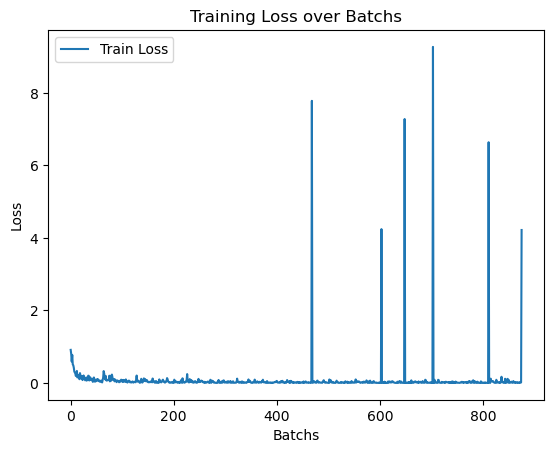

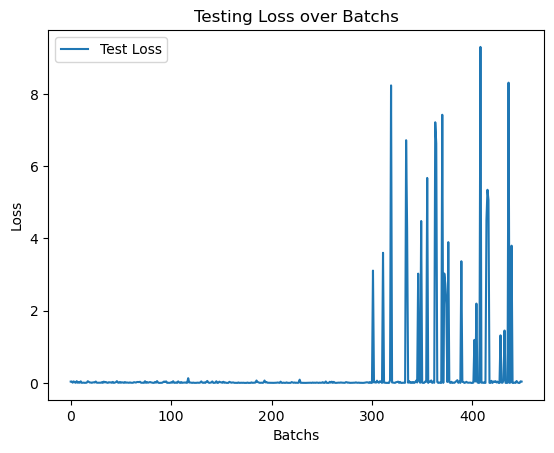

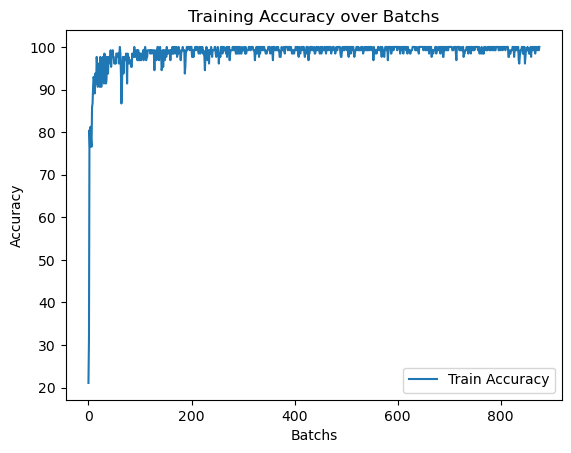

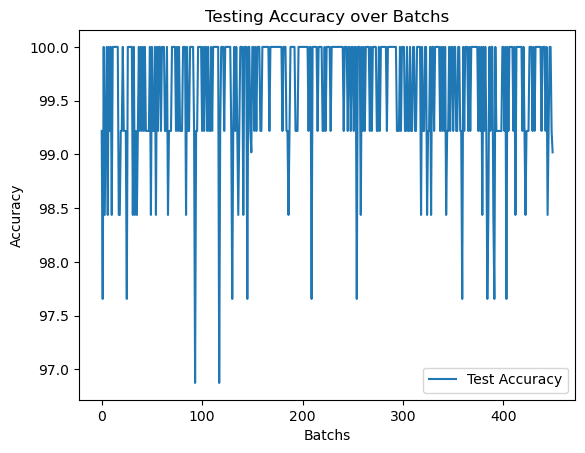

In [21]:
plt.plot(train_loss_history, label='Train Loss')
plt.title('Training Loss over Batchs')
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(test_loss_history, label='Test Loss')
plt.title('Testing Loss over Batchs')
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc_history, label='Train Accuracy')
plt.title('Training Accuracy over Batchs')
plt.xlabel('Batchs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Testing Accuracy over Batchs')
plt.xlabel('Batchs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))
torch.cuda.empty_cache()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  38676 KiB |    994 MiB |   1653 GiB |   1653 GiB |
|       from large pool |  37120 KiB |    993 MiB |   1648 GiB |   1648 GiB |
|       from small pool |   1556 KiB |      3 MiB |      5 GiB |      5 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  38676 KiB |    994 MiB |   1653 GiB |   1653 GiB |
|       from large pool |  37120 KiB |    993 MiB |   1648 GiB |